In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# If your notebook is in model/notebooks
REPO_ROOT = Path.cwd().parent.parent
BACKEND_DIR = REPO_ROOT / "backend"
sys.path.insert(0, str(BACKEND_DIR))


Fetching data for TSLA...


[*********************100%***********************]  1 of 1 completed


Loaded 262 rows. Latest date: 2026-02-23 00:00:00
Data type of prices: <class 'pandas.Series'>


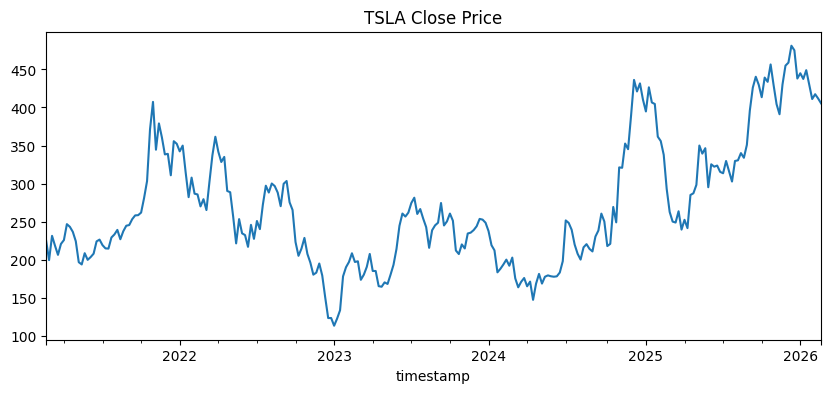

In [ ]:
SYMBOL = "TSLA"
INTERVAL = "1wk"
PERIOD = "5y"

print(f"Fetching data for {SYMBOL}...")

df = yf.download(tickers=SYMBOL, period=PERIOD, interval=INTERVAL, multi_level_index=False)

df = df.reset_index().rename(columns={"Date": "timestamp", "Close": "close"})
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp")

prices = df.set_index("timestamp")["close"].astype(float).dropna()

print(f"Loaded {len(prices)} rows. Latest date: {prices.index.max()}")
print(f"Data type of prices: {type(prices)}") # Verified as <class 'pandas.core.series.Series'>
prices.head()

prices.plot(title=f"{SYMBOL} Close Price", figsize=(10,4))
plt.show()

In [3]:
LOOKBACK = 20  # same concept as LSTM lookback

tmp = pd.DataFrame({"y": prices})
for i in range(1, LOOKBACK + 1):
    tmp[f"lag_{i}"] = tmp["y"].shift(i)

# Target: next week's price (1-step ahead)
tmp["y_next"] = tmp["y"].shift(-1)

model_df = tmp.dropna().copy()
feature_cols = [c for c in model_df.columns if c.startswith("lag_")]

model_df.head(), model_df.shape

(                     y       lag_1       lag_2       lag_3       lag_4  \
 timestamp                                                                
 2021-07-12  214.740005  218.983337  226.300003  223.956665  207.770004   
 2021-07-19  214.460007  214.740005  218.983337  226.300003  223.956665   
 2021-07-26  229.066666  214.460007  214.740005  218.983337  226.300003   
 2021-08-02  233.033340  229.066666  214.460007  214.740005  218.983337   
 2021-08-09  239.056671  233.033340  229.066666  214.460007  214.740005   
 
                  lag_5       lag_6       lag_7       lag_8       lag_9  ...  \
 timestamp                                                               ...   
 2021-07-12  203.296661  199.683334  208.406662  193.626663  196.580002  ...   
 2021-07-19  207.770004  203.296661  199.683334  208.406662  193.626663  ...   
 2021-07-26  223.956665  207.770004  203.296661  199.683334  208.406662  ...   
 2021-08-02  226.300003  223.956665  207.770004  203.296661  199.683334  

In [ ]:
from xgboost import XGBRegressor
from math import sqrt

TEST_SIZE = 30

def walk_forward_xgb(df, feature_cols, target_col, test_size, params):
    preds = []
    split = len(df) - test_size

    for i in range(split, len(df)):
        train = df.iloc[:i]
        test_row = df.iloc[i:i+1]

        X_train = train[feature_cols]
        y_train = train[target_col]
        X_test = test_row[feature_cols]

        model = XGBRegressor(**params)
        model.fit(X_train, y_train)

        y_true = float(test_row[target_col].iloc[0])
        y_pred = float(model.predict(X_test)[0])

        preds.append({"timestamp": test_row.index[0], "y_true": y_true, "y_pred": y_pred})

    return pd.DataFrame(preds).set_index("timestamp")

def metrics(df_pred):
    y = df_pred["y_true"].to_numpy()
    yhat = df_pred["y_pred"].to_numpy()
    mae = np.mean(np.abs(y - yhat))
    rmse = sqrt(np.mean((y - yhat)**2))
    mape = np.mean(np.abs((y - yhat) / y)) * 100
    return {"MAE": mae, "RMSE": rmse, "MAPE_%": mape}

# Define parameter grid
param_grid = {
    'n_estimators': [100, 300, 600],
    'learning_rate': [0.01, 0.03, 0.05],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_lambda': [0.5, 1.0, 2.0],
}

# Use walk-forward validation on training data
X_train = model_df[feature_cols].iloc[:-TEST_SIZE]
y_train = model_df["y_next"].iloc[:-TEST_SIZE]

xgb = XGBRegressor(random_state=42, objective="reg:squarederror")
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

params = grid_search.best_params_
print("Best params:", params)

xgb_pred = walk_forward_xgb(model_df, feature_cols, "y_next", TEST_SIZE, params)
metrics(xgb_pred)

({'MAE': np.float64(34.15416463216146),
  'RMSE': 45.81807203136481,
  'MAPE_%': np.float64(8.003907362803323)},
                 y_true      y_pred
 timestamp                         
 2025-07-28  329.649994  305.220276
 2025-08-04  330.559998  313.296082
 2025-08-11  340.010010  323.979309
 2025-08-18  333.869995  323.555725
 2025-08-25  350.839996  326.176483)

In [5]:
xgb_metrics = metrics(xgb_pred)
print("XGBoost (lags-only) metrics:")
for k, v in xgb_metrics.items():
    print(f"  {k}: {v:,.4f}")

XGBoost (lags-only) metrics:
  MAE: 34.1542
  RMSE: 45.8181
  MAPE_%: 8.0039


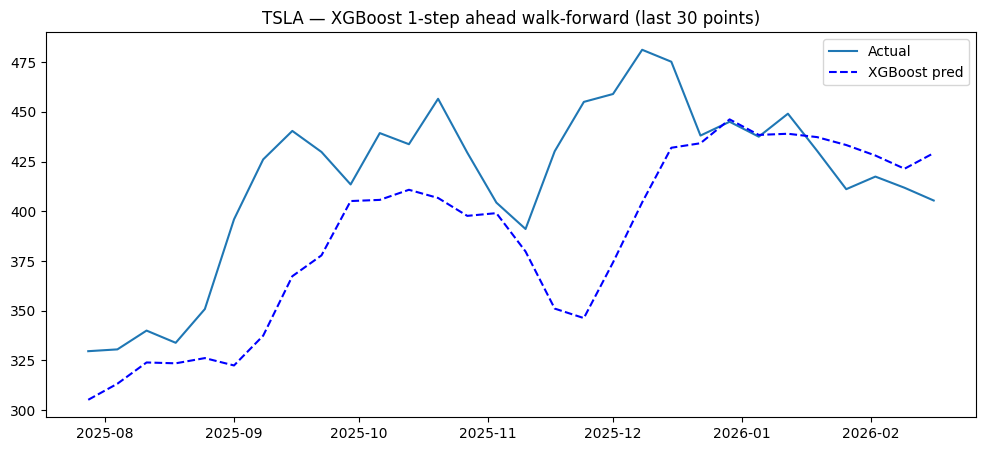

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(xgb_pred.index, xgb_pred["y_true"], label="Actual")
plt.plot(xgb_pred.index, xgb_pred["y_pred"], label="XGBoost pred", color = 'blue', ls='--')
plt.title(f"{SYMBOL} — XGBoost 1-step ahead walk-forward (last {TEST_SIZE} points)")
plt.legend()
plt.show()

In [7]:
from math import sqrt

def backtest_one_step(prices_full: pd.Series, test_size: int, model_factory, min_train: int):
    """
    Walk-forward 1-step backtest with expanding window.
    
    model_factory: callable that returns a NEW model instance each iteration
    min_train: minimum samples required before first forecast
    """
    preds = []
    
    split_idx = len(prices_full) - test_size
    for i in range(split_idx, len(prices_full)):
        train = prices_full.iloc[:i]
        actual = float(prices_full.iloc[i])
        ts = prices_full.index[i]
        
        if len(train) < min_train:
            continue
        
        model = model_factory()
        model.fit(train)
        fc = model.forecast(periods=1)
        yhat = float(fc["point_forecast"][0])
        
        preds.append({"timestamp": ts, "y_true": actual, "y_pred": yhat})
    
    out = pd.DataFrame(preds).set_index("timestamp")
    return out

Baseline metrics: {'MAE': np.float64(41.57410976399739), 'RMSE': 50.986271034555884, 'MAPE_%': np.float64(9.730033182038703)}
XGBoost metrics: {'MAE': np.float64(34.15416463216146), 'RMSE': 45.81807203136481, 'MAPE_%': np.float64(8.003907362803323)}


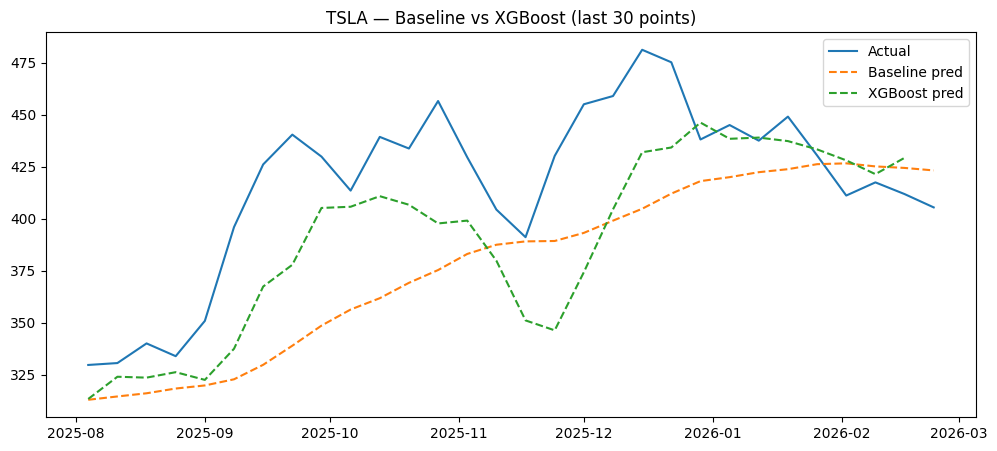

In [11]:
from analytics.forecasting.base import SimpleForecaster

BASELINE_SPAN = 20

baseline_pred = backtest_one_step(
    prices_full=prices,
    test_size=TEST_SIZE,
    model_factory=lambda: SimpleForecaster(span=BASELINE_SPAN, confidence_level=0.95),
    min_train=BASELINE_SPAN
)

print("Baseline metrics:", metrics(baseline_pred))
print("XGBoost metrics:", metrics(xgb_pred))

plot_df = baseline_pred.join(xgb_pred, lsuffix="_base", rsuffix="_xgb")

plt.figure(figsize=(12,5))
plt.plot(plot_df.index, plot_df["y_true_base"], label="Actual")
plt.plot(plot_df.index, plot_df["y_pred_base"], label="Baseline pred", ls='--')
plt.plot(plot_df.index, plot_df["y_pred_xgb"], label="XGBoost pred", ls ='--')
plt.title(f"{SYMBOL} — Baseline vs XGBoost (last {TEST_SIZE} points)")
plt.legend()
plt.show()

In [12]:
OUTDIR = REPO_ROOT / "model" / "notebooks" / "artifacts"
OUTDIR.mkdir(parents=True, exist_ok=True)

xgb_path = OUTDIR / "pred_xgb_weekly_price.parquet"
xgb_pred.reset_index().to_parquet(xgb_path, index=False)
print("Saved:", xgb_path)

Saved: c:\capstone_project_unfc\model\notebooks\artifacts\pred_xgb_weekly_price.parquet


In [13]:
compare = pd.DataFrame([
    {"Model": "Baseline (EWM SimpleForecaster)", **metrics(baseline_pred)},
    {"Model": "XGBoost", **metrics(xgb_pred)},
]).set_index("Model")

compare

,MAE,RMSE,MAPE_%
Model,,,
Baseline (EWM SimpleForecaster),41.574110,50.986271,9.730033
XGBoost,34.154165,45.818072,8.003907
